<a href="https://colab.research.google.com/github/ridhiverma2019/TEAM-13/blob/LBP/LBP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ====== Setup Cell ======
# Install extra libraries (only needed once)
!pip install scikit-image seaborn matplotlib

# Mount Google Drive (uncomment if dataset is in Drive)
#from google.colab import drive
#drive.mount('/content/drive')

# Upload dataset zip file (if not using Drive)
from google.colab import files
uploaded = files.upload()

# If uploaded, unzip it (adjust filename if needed)
!unzip dataset.zip -d dataset

print("✅ Setup complete. Now run Block 1 (LBP Feature Extraction).")

Saving dataset_split.zip to dataset_split.zip
unzip:  cannot find or open dataset.zip, dataset.zip.zip or dataset.zip.ZIP.
✅ Setup complete. Now run Block 1 (LBP Feature Extraction).


In [3]:
import os

# List all files in current directory
print(os.listdir())

# Pick the correct zip file name from the list

['.config', 'dataset_split.zip', 'sample_data']


In [4]:
import zipfile
import os

zip_path = "dataset_split.zip"  # use the correct file

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(".")

# Check folder structure
print(os.listdir("dataset_split"))

['train', 'test']


In [5]:
#_________________________________PREPROCESSING________________________________________________
import os
import cv2
import numpy as np

# -------------------------------
# CONFIG
# -------------------------------
DATASET_DIR = "dataset_split"  # replace with your dataset root
IMG_SIZE = (128, 128)                        # resize to 138x128

def preprocess_images(folder, class_names):
    images, labels = [], []
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(folder, class_name)
        if not os.path.isdir(class_path):
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)

            # Read as grayscale
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            # Resize
            img = cv2.resize(img, IMG_SIZE)

            # Normalize [0,1]
            img = img.astype("float32") / 255.0

            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# -------------------------------
# MAIN (Preprocessing)
# -------------------------------
train_dir = os.path.join(DATASET_DIR, "train")
test_dir = os.path.join(DATASET_DIR, "test")

class_names = sorted(os.listdir(train_dir))

# Preprocess train & test
X_train, y_train = preprocess_images(train_dir, class_names)
X_test, y_test = preprocess_images(test_dir, class_names)

# Save preprocessed data
np.savez_compressed("preprocessed_dataset.npz",
                    X_train=X_train, y_train=y_train,
                    X_test=X_test, y_test=y_test,
                    class_names=class_names)

print("✅ Preprocessing complete")
print("Train set:", X_train.shape, y_train.shape)
print("Test set :", X_test.shape, y_test.shape)
print("Classes  :", class_names)

✅ Preprocessing complete
Train set: (2049, 128, 128) (2049,)
Test set : (515, 128, 128) (515,)
Classes  : ['African elephant', 'Egyptian cat', 'German shepherd', 'Labrador retriever', 'dragonfly', 'golden retriever', 'gorilla', 'koala', 'monarch', 'peacock', 'rose', 'sports car']


Train: (2049, 128, 128) (2049,)
Test : (515, 128, 128) (515,)
Classes: ['African elephant' 'Egyptian cat' 'German shepherd' 'Labrador retriever'
 'dragonfly' 'golden retriever' 'gorilla' 'koala' 'monarch' 'peacock'
 'rose' 'sports car']


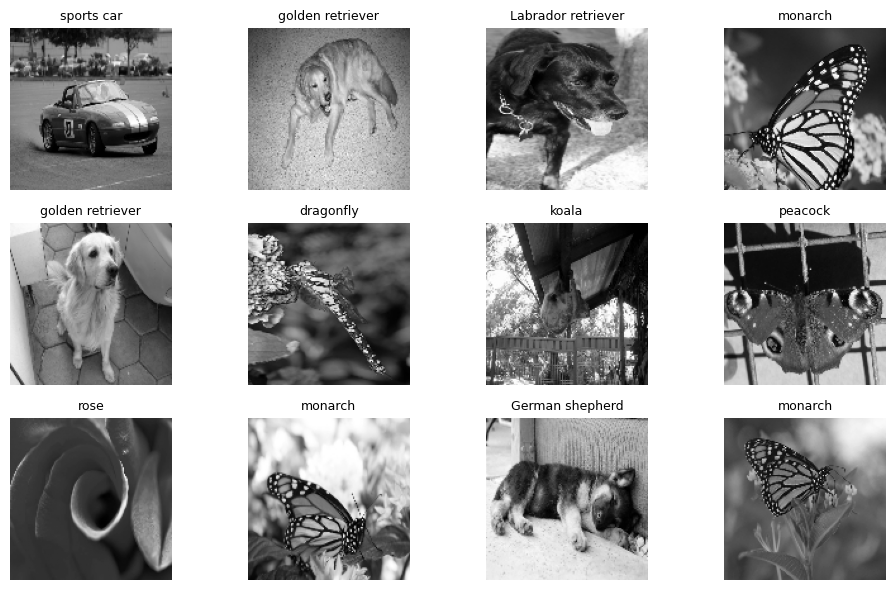

In [6]:
#_____________________________VISUALIZATION OF PREPROCCESSED DATA____________________________________________________________
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# LOAD PREPROCESSED DATA
# -------------------------------
data = np.load("preprocessed_dataset.npz", allow_pickle=True)

X_train, y_train = data["X_train"], data["y_train"]
X_test, y_test = data["X_test"], data["y_test"]
class_names = data["class_names"]

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)
print("Classes:", class_names)

# -------------------------------
# VISUALIZE SOME IMAGES
# -------------------------------
plt.figure(figsize=(10, 6))

for i in range(12):  # show 12 random images
    idx = np.random.randint(0, X_train.shape[0])
    img = X_train[idx].squeeze()  # remove channel dim
    label = class_names[y_train[idx]]

    plt.subplot(3, 4, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(label, fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [7]:
#___________________________________________LPB EXTRATION___________________________________________________________
import numpy as np
from skimage.feature import local_binary_pattern

# -------------------------------
# CONFIG
# -------------------------------
RADIUS = 1
N_POINTS = 8 * RADIUS
METHOD = "uniform"

# -------------------------------
# LOAD PREPROCESSED DATA
# -------------------------------
data = np.load("preprocessed_dataset.npz", allow_pickle=True)
X_train, y_train = data["X_train"], data["y_train"]
X_test, y_test = data["X_test"], data["y_test"]
class_names = data["class_names"]

def extract_lbp_features(images):
    features = []
    for img in images:
        lbp = local_binary_pattern(img, N_POINTS, RADIUS, METHOD)
        hist, _ = np.histogram(
            lbp.ravel(),
            bins=np.arange(0, N_POINTS + 3),
            range=(0, N_POINTS + 2)
        )
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)  # normalize
        features.append(hist)
    return np.array(features)

# Extract LBP histograms
X_train_lbp = extract_lbp_features(X_train)
X_test_lbp = extract_lbp_features(X_test)

# Save LBP dataset
np.savez_compressed("lbp_features_dataset.npz",
                    X_train=X_train_lbp, y_train=y_train,
                    X_test=X_test_lbp, y_test=y_test,
                    class_names=class_names)

print("✅ LBP feature extraction complete")
print("Train features:", X_train_lbp.shape)
print("Test features :", X_test_lbp.shape)
print("Classes       :", class_names)#

/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


✅ LBP feature extraction complete
Train features: (2049, 10)
Test features : (515, 10)
Classes       : ['African elephant' 'Egyptian cat' 'German shepherd' 'Labrador retriever'
 'dragonfly' 'golden retriever' 'gorilla' 'koala' 'monarch' 'peacock'
 'rose' 'sports car']


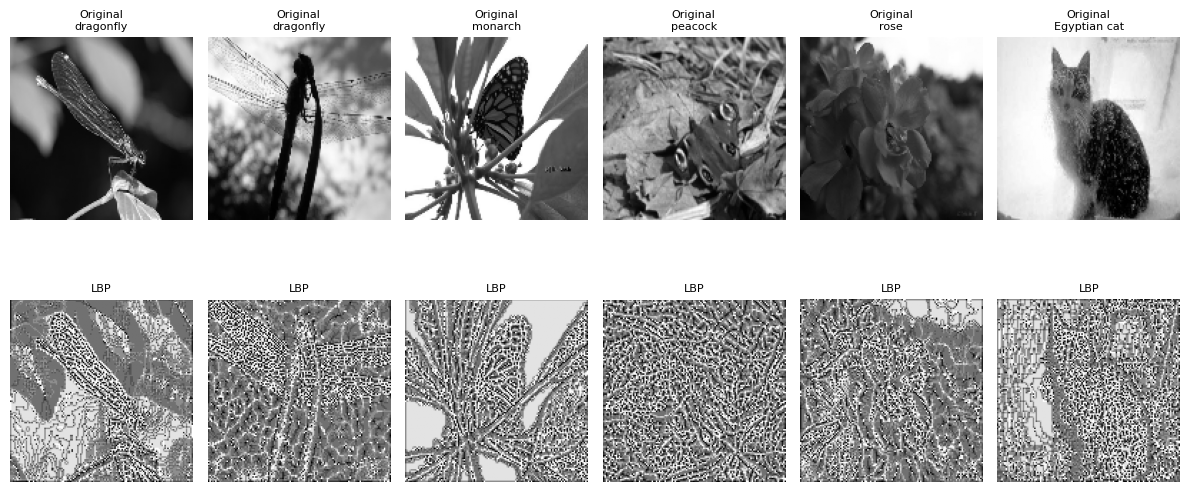

In [8]:
#_______________________________VISUALIZATION AFTER LBP EXTRACTION_________________________________________________
import matplotlib.pyplot as plt

# Pick some random indices
num_samples = 100
indices = np.random.choice(len(X_train), size=6, replace=False)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    # Original image
    plt.subplot(2, 6, i+1)
    plt.imshow(X_train[idx].squeeze(), cmap="gray")
    plt.title(f"Original\n{class_names[y_train[idx]]}", fontsize=8)
    plt.axis("off")

    # LBP image
    lbp_img = local_binary_pattern(X_train[idx].squeeze(), N_POINTS, RADIUS, METHOD)
    plt.subplot(2, 6, i+7)
    plt.imshow(lbp_img, cmap="gray")
    plt.title("LBP", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [9]:
#______________________________________USES LBP EXTRACTION WITH LBP HISTOGRAMS_________________________________________
import numpy as np
from skimage.feature import local_binary_pattern

# -------------------------------
# CONFIG
# -------------------------------
RADIUS = 1
N_POINTS = 8 * RADIUS
METHOD = "uniform"

# -------------------------------
# LOAD PREPROCESSED DATA
# -------------------------------
data = np.load("preprocessed_dataset.npz", allow_pickle=True)
X_train, y_train = data["X_train"], data["y_train"]
X_test, y_test = data["X_test"], data["y_test"]
class_names = data["class_names"]

# -------------------------------
# LBP IMAGE BLOCK
# -------------------------------
def compute_lbp_images(images):
    lbp_images = []
    for img in images:
        lbp_img = local_binary_pattern(img, N_POINTS, RADIUS, METHOD)
        lbp_images.append(lbp_img)
    return np.array(lbp_images)

# Compute LBP images (optional: for visualization or further processing)
X_train_lbp_images = compute_lbp_images(X_train)
X_test_lbp_images  = compute_lbp_images(X_test)

# -------------------------------
# FEATURE EXTRACTION BLOCK (LBP HISTOGRAMS)
# -------------------------------
def extract_lbp_histograms(lbp_images):
    features = []
    for lbp in lbp_images:
        hist, _ = np.histogram(
            lbp.ravel(),
            bins=np.arange(0, N_POINTS + 3),
            range=(0, N_POINTS + 2)
        )
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)  # normalize
        features.append(hist)
    return np.array(features)

# Extract LBP histograms
X_train_lbp_features = extract_lbp_histograms(X_train_lbp_images)
X_test_lbp_features  = extract_lbp_histograms(X_test_lbp_images)

# -------------------------------
# SAVE LBP FEATURES
# -------------------------------
np.savez_compressed(
    "lbp_features_dataset.npz",
    X_train=X_train_lbp_features, y_train=y_train,
    X_test=X_test_lbp_features, y_test=y_test,
    class_names=class_names
)

print("✅ LBP image computation and histogram feature extraction complete")
print("Train features shape:", X_train_lbp_features.shape)
print("Test features shape :", X_test_lbp_features.shape)
print("Classes             :", class_names)

✅ LBP image computation and histogram feature extraction complete
Train features shape: (2049, 10)
Test features shape : (515, 10)
Classes             : ['African elephant' 'Egyptian cat' 'German shepherd' 'Labrador retriever'
 'dragonfly' 'golden retriever' 'gorilla' 'koala' 'monarch' 'peacock'
 'rose' 'sports car']


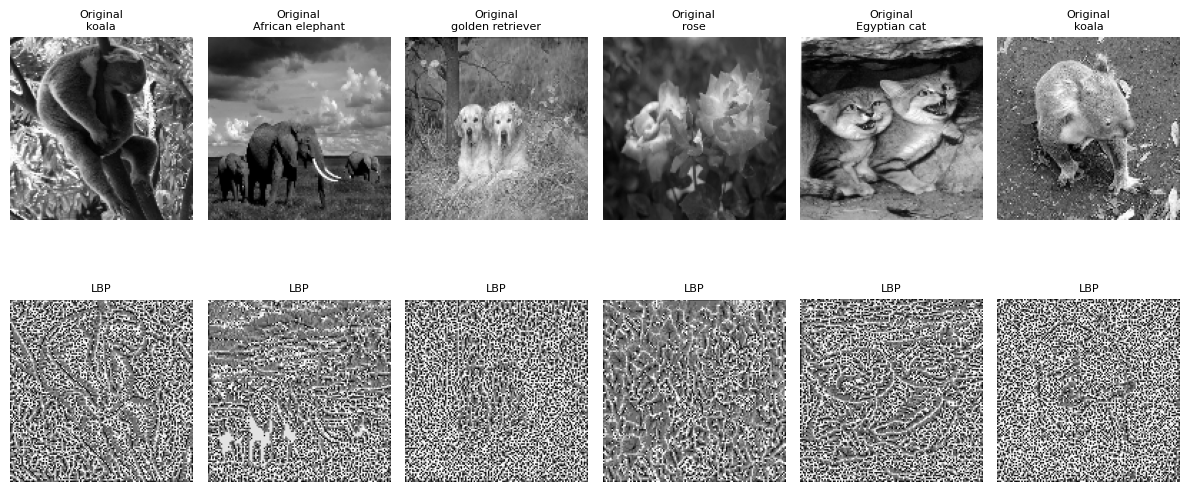

In [10]:
#__________________________________________#VISUALIZATION OF DATA__________________________________________________________________
import matplotlib.pyplot as plt

# Pick some random indices
num_samples = 20
indices = np.random.choice(len(X_train), size=6, replace=False)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    # Original image
    plt.subplot(2, 6, i+1)
    plt.imshow(X_train[idx].squeeze(), cmap="gray")
    plt.title(f"Original\n{class_names[y_train[idx]]}", fontsize=8)
    plt.axis("off")

    # LBP image
    lbp_img = local_binary_pattern(X_train[idx].squeeze(), N_POINTS, RADIUS, METHOD)
    plt.subplot(2, 6, i+7)
    plt.imshow(lbp_img, cmap="gray")
    plt.title("LBP", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [11]:
# -------------------------------
# BLOCK 1: MULTI-SCALE LBP FEATURE EXTRACTION
# -------------------------------
import numpy as np
from skimage.feature import local_binary_pattern

# -------------------------------
# CONFIG
# -------------------------------
RADIUS_LIST = [1, 2, 3]  # multi-scale
METHOD = "uniform"

# -------------------------------
# LOAD PREPROCESSED DATA
# -------------------------------
data = np.load("preprocessed_dataset.npz", allow_pickle=True)
X_train, y_train = data["X_train"], data["y_train"]
X_test, y_test = data["X_test"], data["y_test"]
class_names = data["class_names"]

# -------------------------------
# MULTI-SCALE LBP FEATURE EXTRACTION
# -------------------------------
def extract_multiscale_lbp(img, radii=RADIUS_LIST):
    features = []
    for r in radii:
        n_points = 8 * r
        lbp = local_binary_pattern(img, n_points, r, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype('float')
        hist /= (hist.sum() + 1e-7)  # normalize
        features.append(hist)
    return np.hstack(features)

def extract_features_dataset(images):
    return np.array([extract_multiscale_lbp(img) for img in images])

# Extract features
X_train_features = extract_features_dataset(X_train)
X_test_features  = extract_features_dataset(X_test)

# -------------------------------
# SAVE FEATURES
# -------------------------------
np.savez_compressed(
    "lbp_multiscale_features_dataset.npz",
    X_train=X_train_features, y_train=y_train,
    X_test=X_test_features, y_test=y_test,
    class_names=class_names
)

print("✅ Multi-scale LBP features ready")
print("Train features shape:", X_train_features.shape)
print("Test features shape :", X_test_features.shape)

✅ Multi-scale LBP features ready
Train features shape: (2049, 54)
Test features shape : (515, 54)


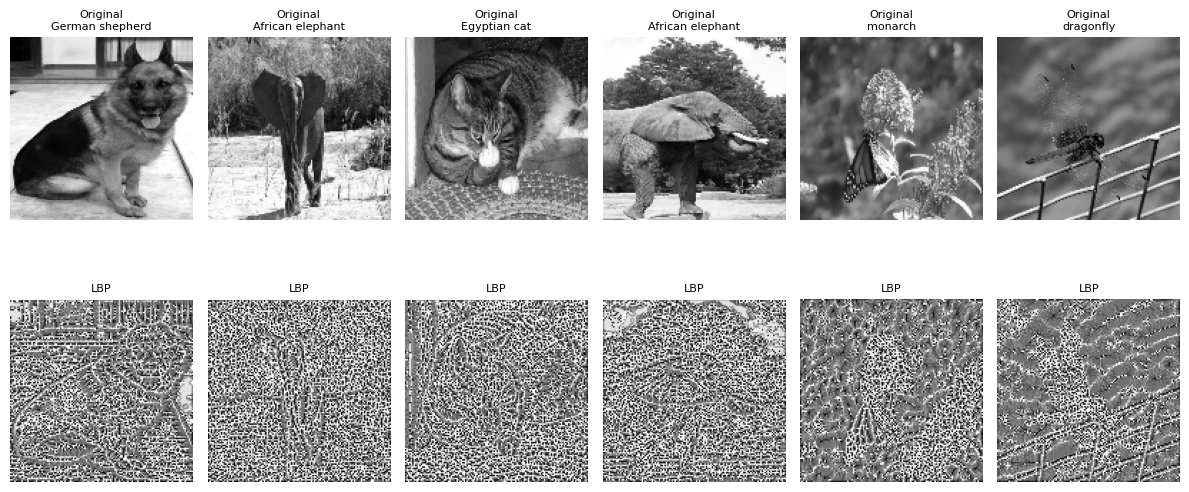

In [12]:
#__________________________________VISUALIZATION AFTER MULTI SCALE LEVEL LBP__________________________________________________________
import matplotlib.pyplot as plt

# Pick some random indices
num_samples = 20
indices = np.random.choice(len(X_train), size=6, replace=False)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    # Original image
    plt.subplot(2, 6, i+1)
    plt.imshow(X_train[idx].squeeze(), cmap="gray")
    plt.title(f"Original\n{class_names[y_train[idx]]}", fontsize=8)
    plt.axis("off")

    # LBP image
    lbp_img = local_binary_pattern(X_train[idx].squeeze(), N_POINTS, RADIUS, METHOD)
    plt.subplot(2, 6, i+7)
    plt.imshow(lbp_img, cmap="gray")
    plt.title("LBP", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


===== Logistic Regression =====
Accuracy: 0.4583, Precision: 0.4416, Recall: 0.4583, F1: 0.4372

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.62      0.51        50
           1       0.33      0.06      0.11        16
           2       0.24      0.13      0.17        38
           3       0.29      0.23      0.26        60
           4       0.55      0.52      0.53        54
           5       0.31      0.28      0.30        46
           6       0.33      0.10      0.15        20
           7       0.44      0.70      0.54        70
           8       0.77      0.79      0.78        68
           9       0.46      0.42      0.44        40
          10       0.38      0.36      0.37        25
          11       0.46      0.46      0.46        28

    accuracy                           0.46       515
   macro avg       0.42      0.39      0.38       515
weighted avg       0.44      0.46      0.44       515



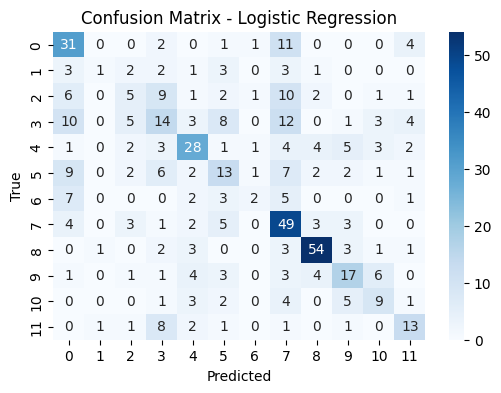

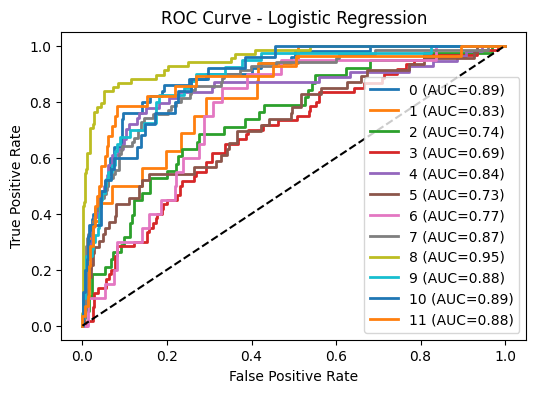


===== Random Forest =====
Accuracy: 0.4155, Precision: 0.3720, Recall: 0.4155, F1: 0.3799

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.48      0.48        50
           1       0.00      0.00      0.00        16
           2       0.00      0.00      0.00        38
           3       0.23      0.27      0.25        60
           4       0.50      0.50      0.50        54
           5       0.38      0.28      0.33        46
           6       0.33      0.05      0.09        20
           7       0.38      0.66      0.48        70
           8       0.56      0.72      0.63        68
           9       0.40      0.30      0.34        40
          10       0.35      0.24      0.29        25
          11       0.44      0.71      0.55        28

    accuracy                           0.42       515
   macro avg       0.34      0.35      0.33       515
weighted avg       0.37      0.42      0.38       515



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


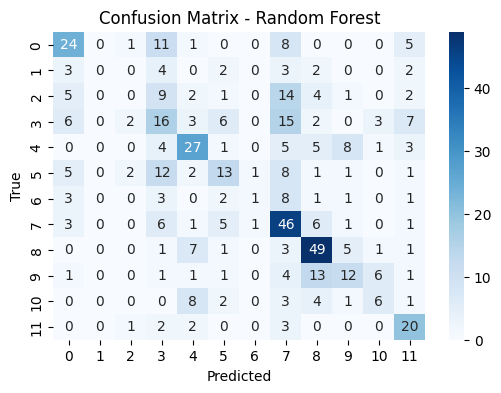

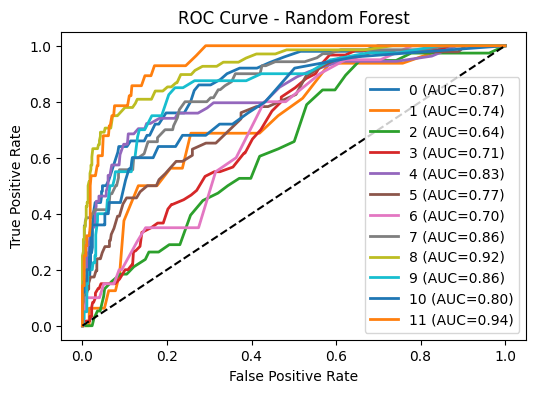

In [15]:
# -------------------------------
# BLOCK 2: CLASSIFIERS FOR LOGISTIC REGRESSION & RANDOM FOREST
# -------------------------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# -------------------------------
# LOAD MULTI-SCALE LBP FEATURE DATA
# -------------------------------
data = np.load("lbp_multiscale_features_dataset.npz", allow_pickle=True)
X_train, y_train = data["X_train"], data["y_train"]
X_test, y_test = data["X_test"], data["y_test"]
class_names = data["class_names"]

# -------------------------------
# CLASSIFIER FUNCTION
# -------------------------------
def train_and_evaluate_classifiers(X_train, y_train, X_test, y_test, class_names):
    # Encode labels
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define classifiers
    classifiers = {
        "Logistic Regression": (LogisticRegression(max_iter=1000, solver='saga'), X_train_scaled, X_test_scaled),
        "Random Forest": (RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42), X_train_scaled, X_test_scaled)
    }

    results = []

    for name, (model, X_tr, X_te) in classifiers.items():
        print("\n=====", name, "=====")

        # Train
        model.fit(X_tr, y_train_enc)

        # Predict
        y_pred = model.predict(X_te)

        # Metrics
        acc = accuracy_score(y_test_enc, y_pred)
        prec = precision_score(y_test_enc, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_test_enc, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test_enc, y_pred, average='weighted', zero_division=0)

        print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
        print("\nClassification Report:\n", classification_report(y_test_enc, y_pred, target_names=[str(c) for c in le.classes_]))

        # Confusion Matrix
        cm = confusion_matrix(y_test_enc, y_pred)
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        # ROC Curve (if predict_proba available)
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_te)
            y_bin = label_binarize(y_test_enc, classes=np.arange(len(le.classes_)))
            plt.figure(figsize=(6,4))
            for i in range(len(le.classes_)):
                fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, lw=2, label=f"{le.classes_[i]} (AUC={roc_auc:.2f})")
            plt.plot([0,1],[0,1],'k--')
            plt.title(f'ROC Curve - {name}')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc='lower right')
            plt.show()

        results.append({"Classifier": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1})

    return results

# -------------------------------
# RUN CLASSIFIERS
# -------------------------------
results = train_and_evaluate_classifiers(X_train, y_train, X_test, y_test, class_names)


/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Train features: (2049, 54)
Test features : (515, 54)
Best k-NN params: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}

--- k-NN Results ---
Accuracy: 0.3631
              precision    recall  f1-score   support

           0       0.38      0.46      0.42        50
           1       0.00      0.00      0.00        16
           2       0.10      0.03      0.04        38
           3       0.14      0.15      0.14        60
           4       0.51      0.44      0.48        54
           5       0.29      0.26      0.28        46
           6       0.00      0.00      0.00        20
           7       0.35      0.69      0.46        70
           8       0.58      0.59      0.58        68
           9       0.37      0.28      0.31        40
          10       0.36      0.16      0.22        25
          11       0.37      0.54      0.43        28

    accuracy                           0.36       515
   macro avg       0.29      0.30      0.28       515
weighted avg

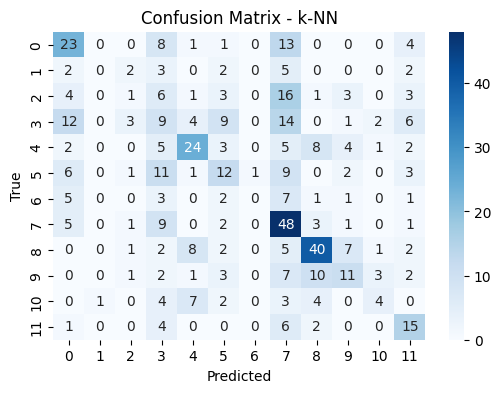

Best Decision Tree params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}

--- Decision Tree (Bagging) Results ---
Accuracy: 0.4039
              precision    recall  f1-score   support

           0       0.42      0.60      0.50        50
           1       0.14      0.06      0.09        16
           2       0.07      0.03      0.04        38
           3       0.22      0.13      0.17        60
           4       0.52      0.54      0.53        54
           5       0.36      0.28      0.32        46
           6       0.00      0.00      0.00        20
           7       0.37      0.63      0.46        70
           8       0.65      0.69      0.67        68
           9       0.34      0.33      0.33        40
          10       0.41      0.28      0.33        25
          11       0.35      0.54      0.42        28

    accuracy                           0.40       515
   macro avg       0.32      0.34      0.32       515
weighted a

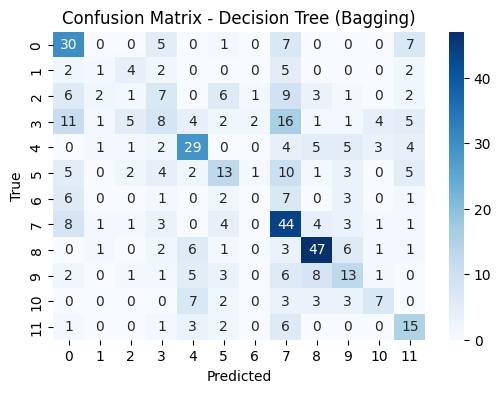

In [17]:
# -------------------------------
# BLOCK 2: CLASSIFIER FOR  k-NN + DECISION TREE (BAGGING)
# -------------------------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# -------------------------------
# CONFIG
# -------------------------------
RADIi = [1,2,3]             # controlled radii for stable features
N_POINTS_FACTOR = 8
METHOD = 'uniform'          # simple & effective

# -------------------------------
# LOAD RAW IMAGE DATA
# -------------------------------
data = np.load("preprocessed_dataset.npz", allow_pickle=True)
X_train, y_train = data["X_train"], data["y_train"]
X_test, y_test = data["X_test"], data["y_test"]
class_names = data["class_names"]

# -------------------------------
# MULTI-SCALE LBP FEATURE EXTRACTION
# -------------------------------
def extract_multiscale_lbp(images, radii=RADIi, n_points_factor=N_POINTS_FACTOR, method=METHOD):
    features = []
    for img in images:
        hist_all = []
        for R in radii:
            N_POINTS = n_points_factor * R
            lbp = local_binary_pattern(img.squeeze(), N_POINTS, R, method)
            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, N_POINTS+3), range=(0, N_POINTS+2))
            hist = hist.astype("float") / (hist.sum() + 1e-7)
            hist_all.extend(hist)
        features.append(hist_all)
    return np.array(features)

X_train_lbp = extract_multiscale_lbp(X_train)
X_test_lbp  = extract_multiscale_lbp(X_test)

print("Train features:", X_train_lbp.shape)
print("Test features :", X_test_lbp.shape)

# -------------------------------
# ENCODE LABELS
# -------------------------------
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# -------------------------------
# SCALE FEATURES
# -------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_lbp)
X_test_scaled  = scaler.transform(X_test_lbp)

# -------------------------------
# PCA - FIXED 50 COMPONENTS
# -------------------------------
pca = PCA(n_components=50, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

# -------------------------------
# k-NN GRID SEARCH (OPTIMIZED)
# -------------------------------
knn_params = {
    'n_neighbors':[3,5,7,9,11,15],
    'weights':['distance'],
    'metric':['euclidean','manhattan']
}

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, n_jobs=-1)
knn_grid.fit(X_train_pca, y_train_enc)
best_knn = knn_grid.best_estimator_
print("Best k-NN params:", knn_grid.best_params_)

# Predict k-NN
y_pred_knn = best_knn.predict(X_test_pca)
acc_knn = accuracy_score(y_test_enc, y_pred_knn)
print(f"\n--- k-NN Results ---\nAccuracy: {acc_knn:.4f}")
print(classification_report(y_test_enc, y_pred_knn, target_names=[str(c) for c in le.classes_]))

# Confusion matrix - k-NN
cm_knn = confusion_matrix(y_test_enc, y_pred_knn)
plt.figure(figsize=(6,4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - k-NN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# -------------------------------
# DECISION TREE (GRIDSEARCH + BAGGING)
# -------------------------------
dt_params = {
    'max_depth':[10,15,20,25],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4],
    'class_weight':['balanced']
}

dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, n_jobs=-1)
dt_grid.fit(X_train_pca, y_train_enc)
best_dt = dt_grid.best_estimator_
print("Best Decision Tree params:", dt_grid.best_params_)

# Bagging Decision Tree
bag_dt = BaggingClassifier(
    estimator=best_dt,
    n_estimators=150,
    max_samples=0.9,
    max_features=0.9,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
bag_dt.fit(X_train_pca, y_train_enc)

# Predict Decision Tree
y_pred_dt = bag_dt.predict(X_test_pca)
acc_dt = accuracy_score(y_test_enc, y_pred_dt)
print(f"\n--- Decision Tree (Bagging) Results ---\nAccuracy: {acc_dt:.4f}")
print(classification_report(y_test_enc, y_pred_dt, target_names=[str(c) for c in le.classes_]))

# Confusion matrix - Decision Tree
cm_dt = confusion_matrix(y_test_enc, y_pred_dt)
plt.figure(figsize=(6,4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Decision Tree (Bagging)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


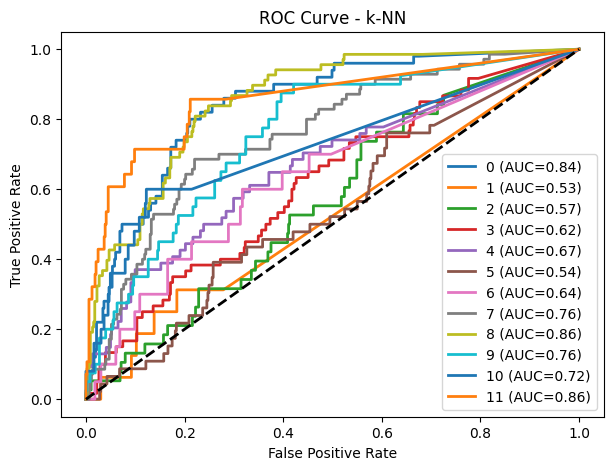

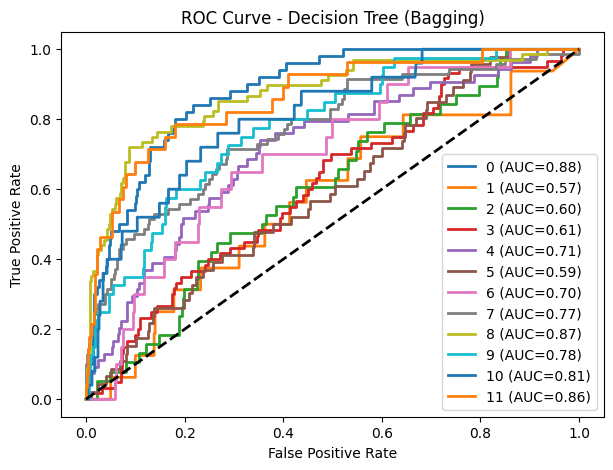

In [22]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the labels for multi-class ROC
y_test_bin = label_binarize(y_test_enc, classes=np.arange(len(le.classes_)))

# -------------------------------
# k-NN ROC Curve
# -------------------------------
if hasattr(best_knn, "predict_proba"):
    y_score_knn = best_knn.predict_proba(X_test_pca)
    plt.figure(figsize=(7,5))
    for i, class_name in enumerate(le.classes_):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_knn[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{class_name} (AUC={roc_auc:.2f})")
    plt.plot([0,1],[0,1],'k--', lw=2)
    plt.title("ROC Curve - k-NN")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

# -------------------------------
# Decision Tree (Bagging) ROC Curve
# -------------------------------
if hasattr(bag_dt, "predict_proba"):
    y_score_dt = bag_dt.predict_proba(X_test_pca)
    plt.figure(figsize=(7,5))
    for i, class_name in enumerate(le.classes_):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_dt[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{class_name} (AUC={roc_auc:.2f})")
    plt.plot([0,1],[0,1],'k--', lw=2)
    plt.title("ROC Curve - Decision Tree (Bagging)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()
